# Track Quality

Since my [CTIDE presentation](https://indico.cern.ch/event/772984/contributions/3211808/attachments/1753088/2841242/Hartman_CTIDE_Nov_14_18.pdf), I've been digging in a bit into these lower level variables trying to gain some intution into what they were doing, etc.



## Table of Contents

1. [Shared hits](#sharedHits)
2. [Number of of Si hits](#nSiHits)
3. [Track multiplicity distribuitons](#nTrkDist)
4. [RNN performance w/ fakes](#rnnPerformance)
5. [RNN Activations: jet with a fake](#fakeTrk)

In [3]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
from tqdm import tqdm 

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *
from matplotlib.colors import LogNorm

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Shared hits <a id='sharedHits'></a>
 
From before, I noticed that there were shared hits from PU in L0 for HF jets than for l-jets. At first I thought maybe this was due to there being more shared hits due to the central core of the jet for HF jets?

Michael said I could test this hypothesis by plotting the # of shared hits as a function of $\Delta R$ from the jet axis. Although this won't tell us whether the relationship is due to correlation or causation.


In [4]:
dataFile = '../data/mc16d_Topo_ttbar/'
dataTag = '3m_15trks_sd0_rev'

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataFile,dataTag), key='jet_df')

trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataFile,dataTag))

In [5]:
trk_xr.coords['var']

<xarray.DataArray 'var' (var: 31)>
array(['sd0', 'sz0', 'ip3d_d0', 'ip3d_z0', 'ip3d_grade', 'ip3d_llr', 'pt',
       'eta', 'theta', 'phi', 'orig', 'algo', 'nNextToInnHits', 'nInnHits',
       'nBLHits', 'nsharedBLHits', 'nsplitBLHits', 'nPixHits', 'nPixHoles',
       'nsharedPixHits', 'nsplitPixHits', 'nSCTHits', 'nSCTHoles',
       'nsharedSCTHits', 'expectBLayerHit', 'expectInnermostPixelLayerHit',
       'expectNextToInnermostPixelLayerHit', 'ptfrac', 'dr', 'prbP', 'pPerp'],
      dtype=object)
Coordinates:
  * var      (var) object 'sd0' 'sz0' 'ip3d_d0' ... 'dr' 'prbP' 'pPerp'

In [6]:
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

f = h5py.File(f_name,"r")
    
X = f['X_test'][:]
y = f['y_test'][:]
y_trk = f['y_trk_test'][:].astype(int)
ix = f['ix_test'][:]

f.close()

In [7]:
trk_origs = trk_xr.loc[:,:,'orig'].values[ix]

In [8]:
y_trks = np.ones_like(X[:,:,0])
y_trks = y_trks * y.reshape(-1,1)

o_trks = np.ones_like(X[:,:,0])
o_trks = o_trks * trk_origs

mask = getTrkMask(X)

y_trks = y_trks[mask]
o_trks = o_trks[mask]

In [9]:
_, nTrks, nFeatures = X.shape

In [10]:
sharedL0Hits = X[:,:,4][mask]
dRs = trk_xr.loc[ix,:,'dr'].values[mask]

In [11]:
sharedPixHits = X[:,:,6][mask]
sharedSCTHits = X[:,:,8][mask]

sharedSiHits = sharedPixHits + sharedSCTHits

In [10]:
myVars = [sharedL0Hits, sharedPixHits, sharedSCTHits, sharedSiHits]

xLabels = ['# of shared IBL hits','# of shared Pixel hits',
             '# of shared SCT hits','# of shared Si hits']

vTags = ['sharedL0Hits','sharedPixHits','sharedSCTHits','sharedSiHits']

nBinsXs = [3,4,7,11]

How many plots is this?
- 4 variables
- 3 flavors
- 4 track categories

In [11]:
4*3*4

48

Plots for # of shared IBL hits


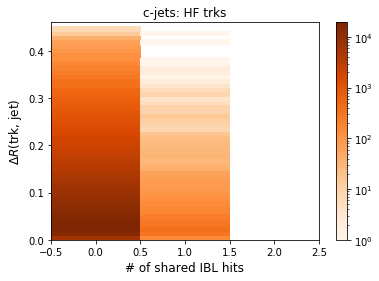

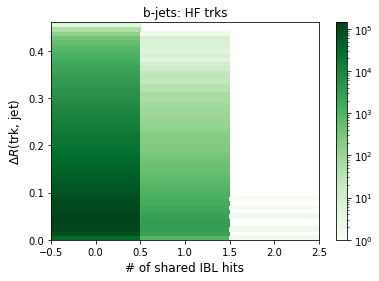

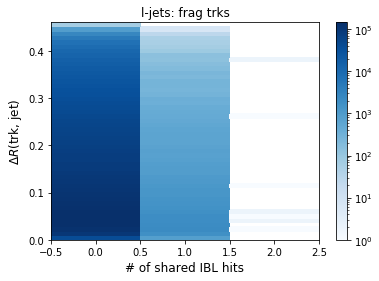

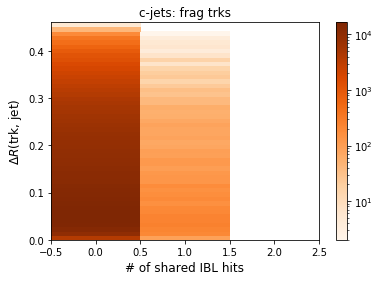

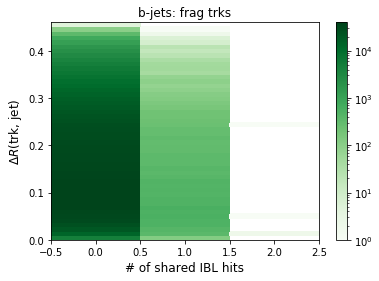

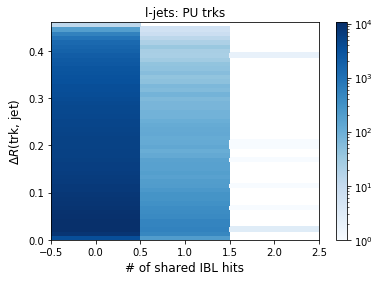

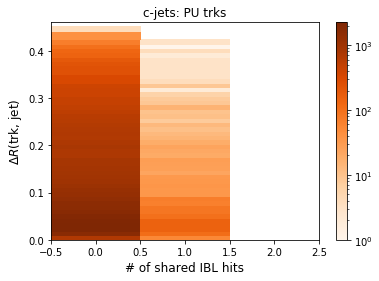

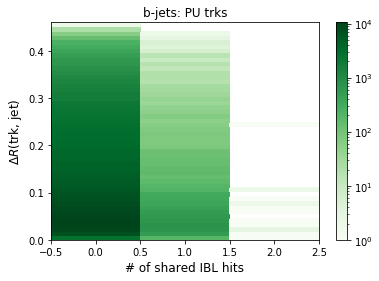

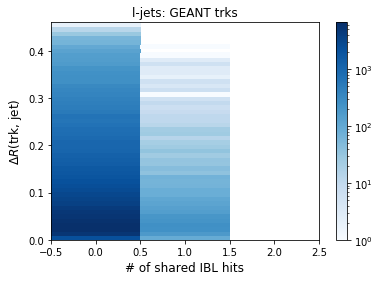

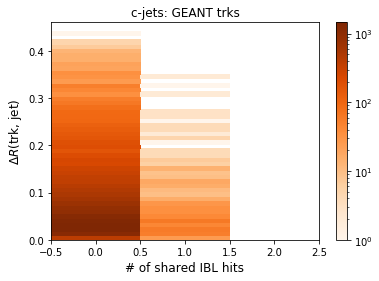

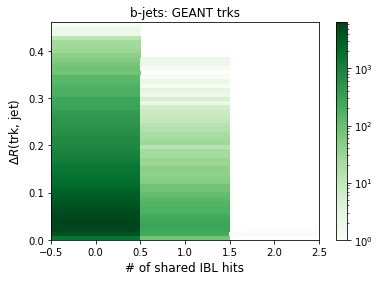

Plots for # of shared Pixel hits


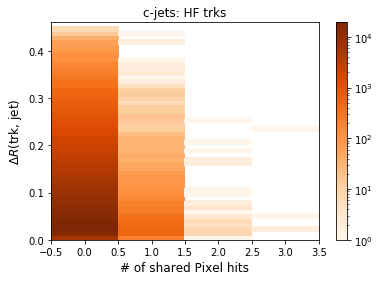

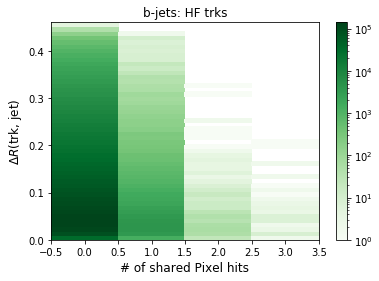

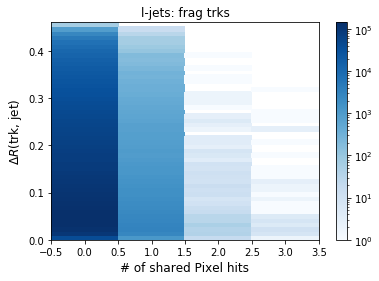

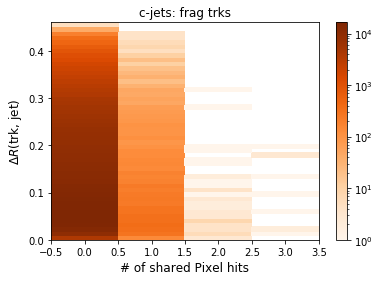

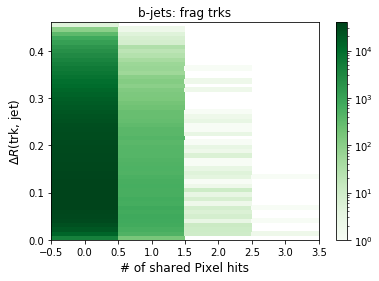

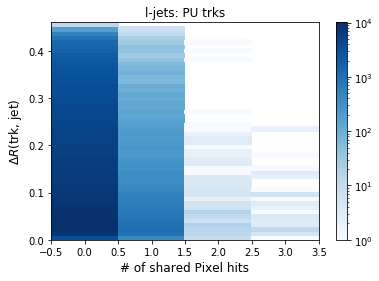

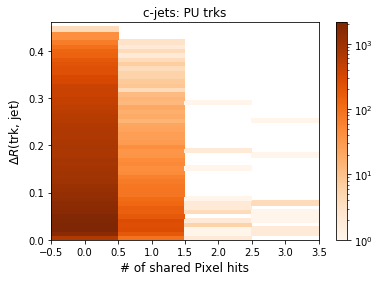

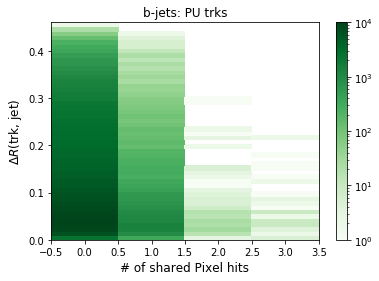

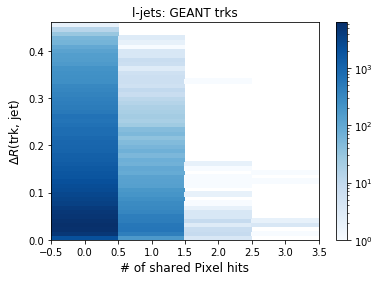

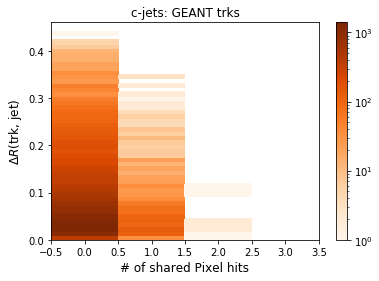

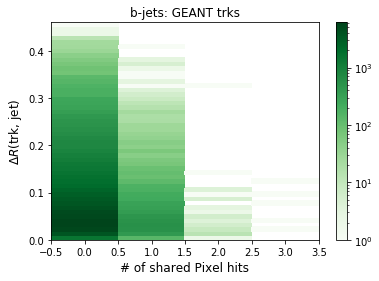

Plots for # of shared SCT hits


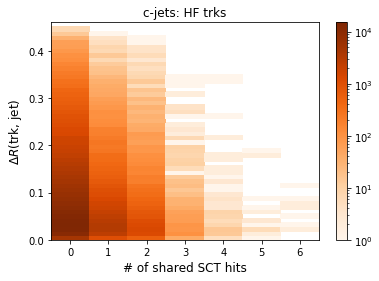

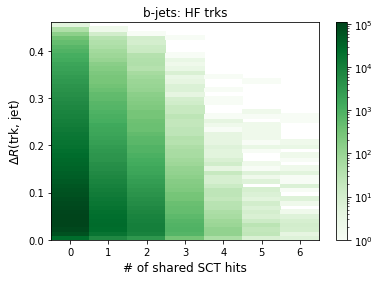

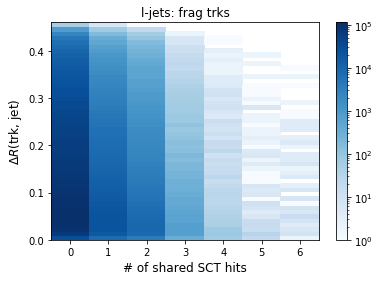

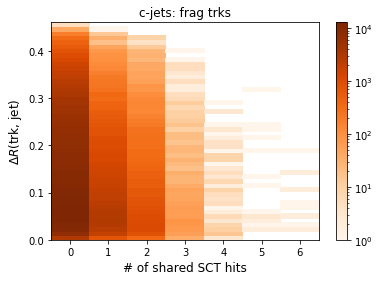

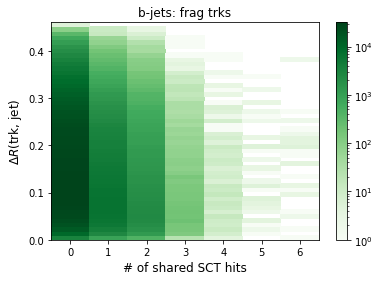

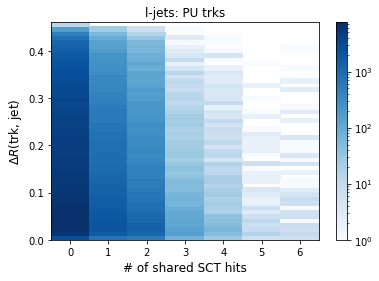

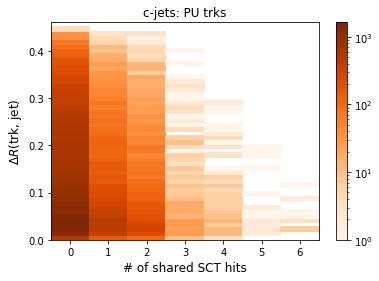

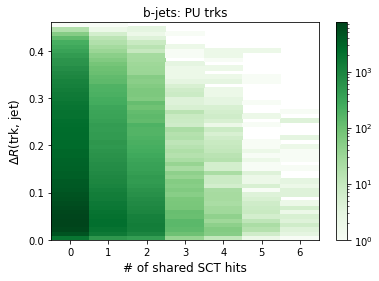

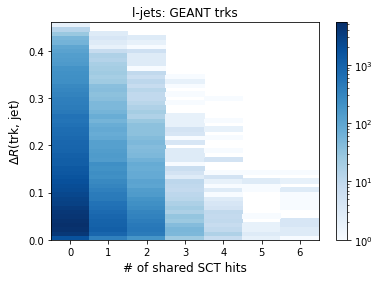

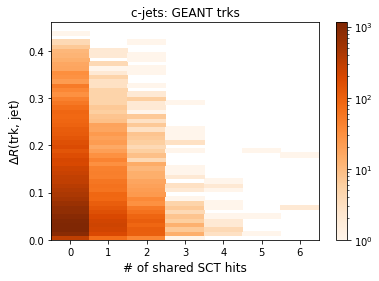

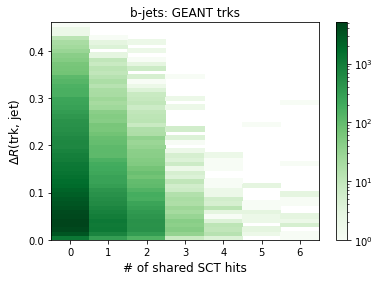

Plots for # of shared Si hits


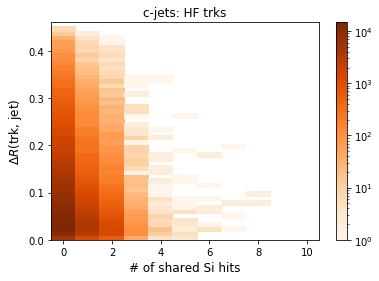

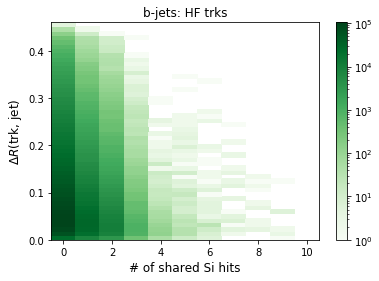

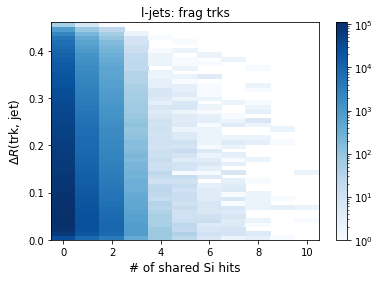

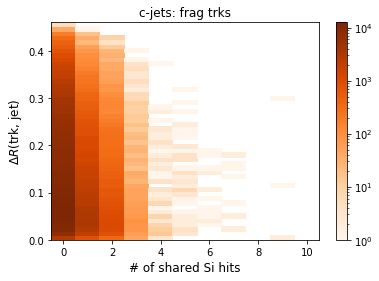

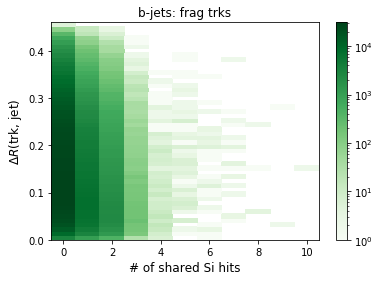

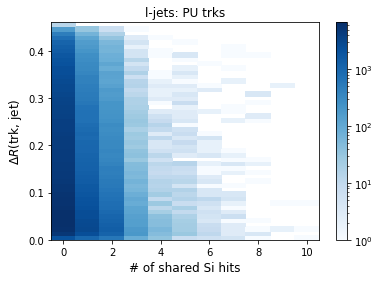

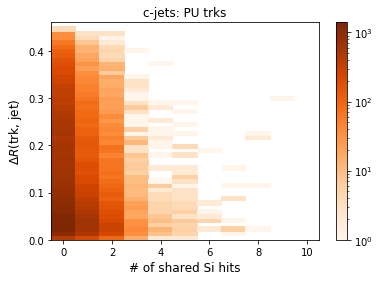

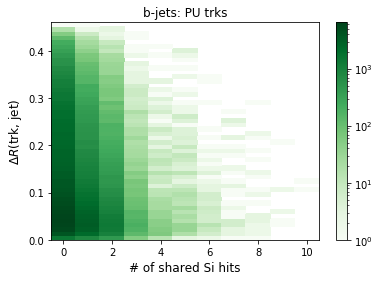

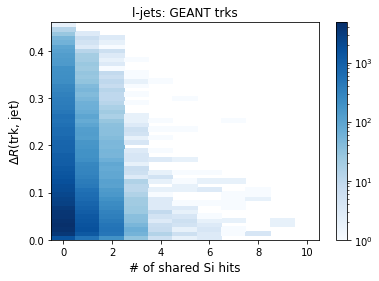

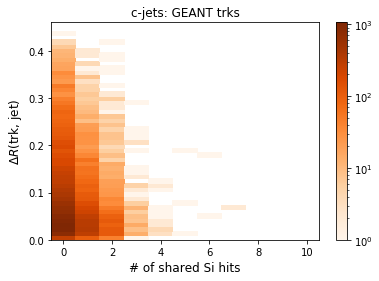

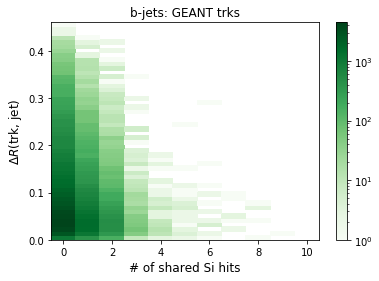

In [12]:
for var, xLabel, vTag, nBinsX in zip(myVars, xLabels, vTags, nBinsXs):

    print('Plots for',xLabel)

    for oi, orig_tag, l in zip([(0,1),2,-1,3],['HF','frag','PU','GEANT'],
                                   ['-', '--', '-.', ':']):

        # Get the mask for the track origin
        if type(oi) == tuple:
            orig_mask = np.zeros_like(y_trks).astype(bool)
            for oix in oi:
                orig_mask = orig_mask | (o_trks==oix)
        else:
            orig_mask = (o_trks==oi)


        for yi, flav, cmap in zip(range(3), ['l','c','b'], ['Blues','Oranges','Greens']):

            if (flav == 'l') and (orig_tag == 'HF'):
                continue

            subfig_mask = orig_mask & (y_trks==yi)

            plt.hist2d(var[subfig_mask],dRs[subfig_mask], 
                       bins=(nBinsX,50),range=((-0.5,nBinsX-0.5),(0,0.46)),
                       norm=LogNorm(), cmap=cmap)

            plt.colorbar()

            plt.title('{}-jets: {} trks'.format(flav, orig_tag))
            plt.xlabel(xLabel, fontsize=12)
            plt.ylabel('$\Delta R$(trk, jet)', fontsize=12)
            
            plt.savefig('../figures/PU_studies/{}_vs_dR_{}jet_{}.pdf'.format(vTag,flav,orig_tag))
            plt.show()

Ok, wow! This is *a lot* of information!!

I think most of the relevant info is actually just in the shared L0 hits plot, and the conclusion that I think makes the most sense is that this effect probably isn't due to the dense core with HF tracks, but rather with the HF tracks leaking into the PU track category, but I think the way that I'll ultimately verify this conclusion is by remaking the distributions changing the truthMatchProb for IDing PU!

**Notes from chatting with Michael:**

Michael told me that what I really want to probe is how the # of shared L0 hits *evolves* as a function of $\Delta R$. So I'm going to probe


$$p(\text{# shared L0 hits} | \alpha \leq \Delta R \leq \beta) $$

by normalizing the above plots *by row*.

He also suggested that I make the $\Delta R$ bins a bit larger as well.

Plots for # of shared IBL hits


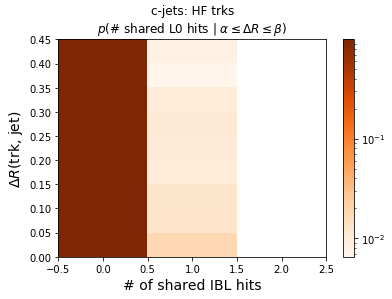

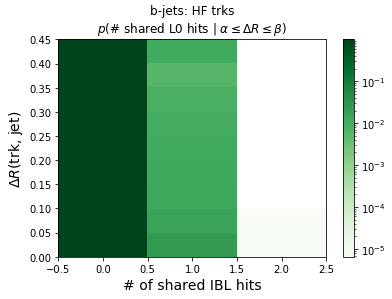

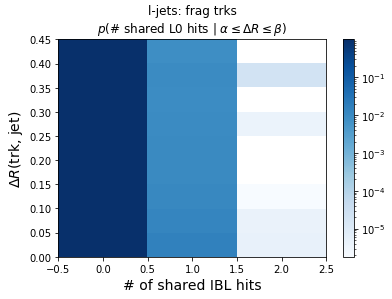

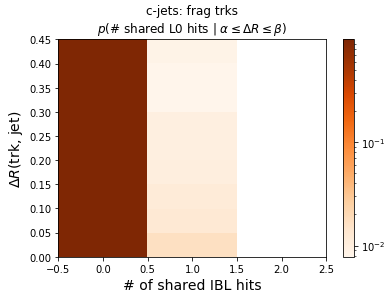

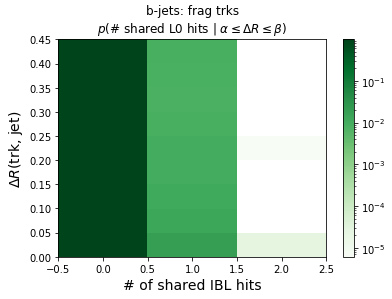

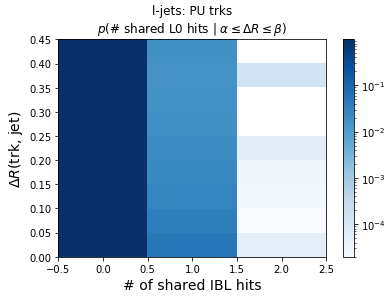

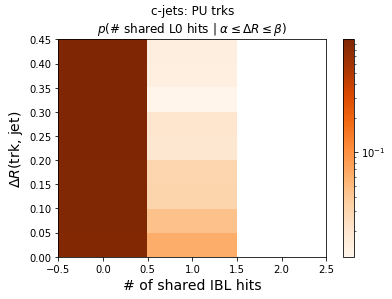

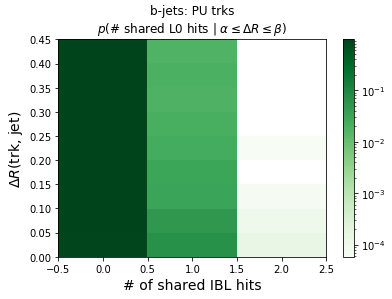

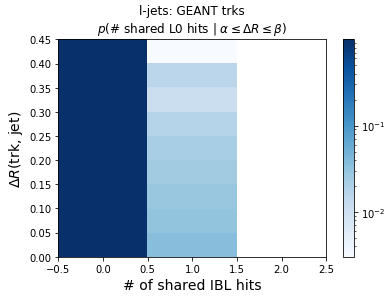

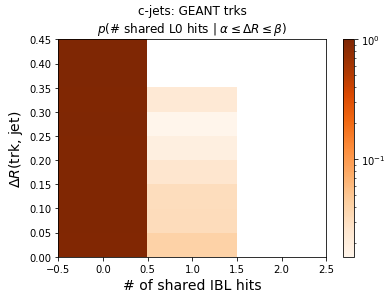

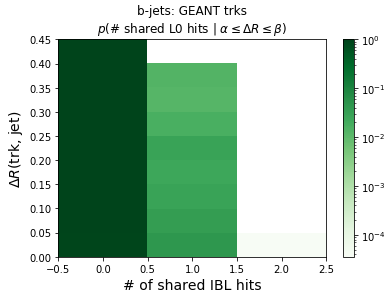

Plots for # of shared Pixel hits


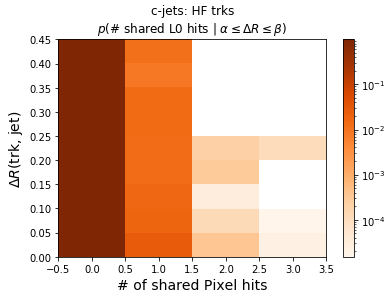

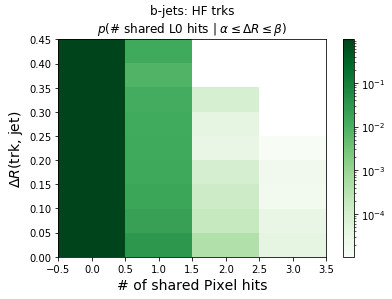

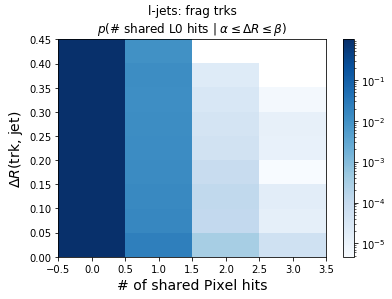

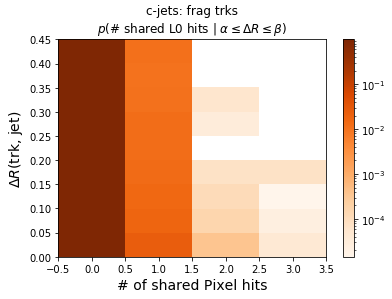

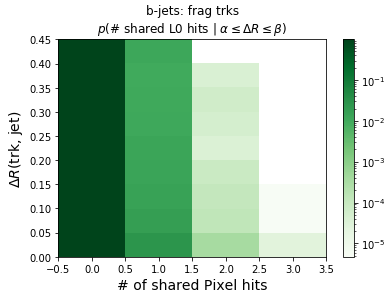

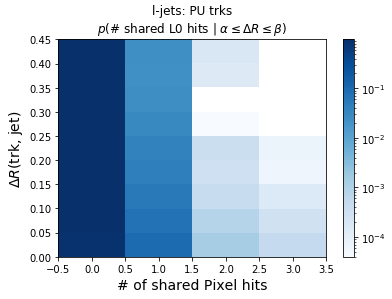

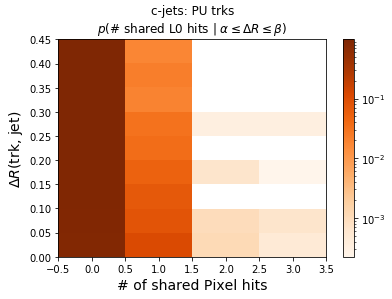

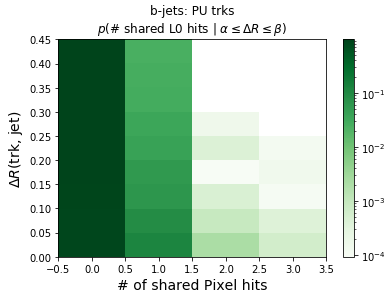

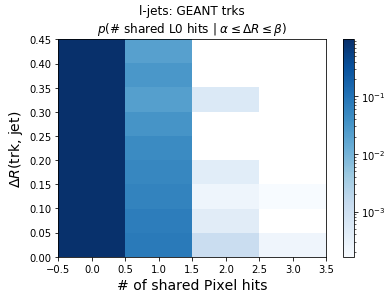

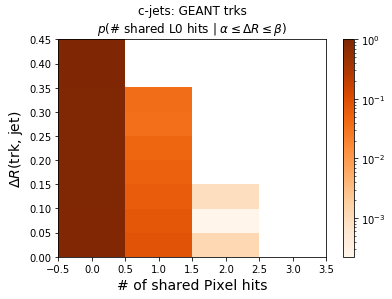

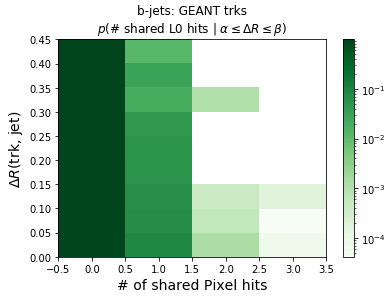

Plots for # of shared SCT hits


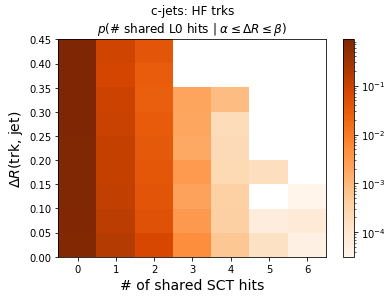

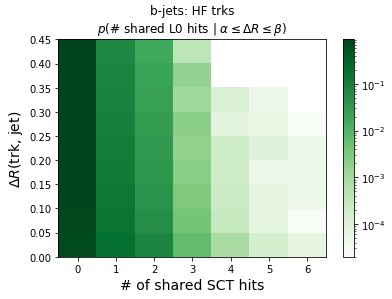

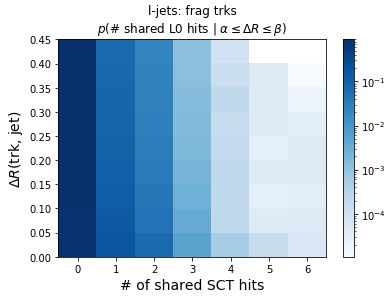

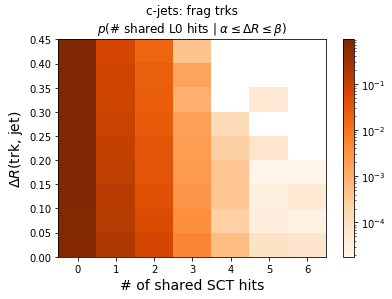

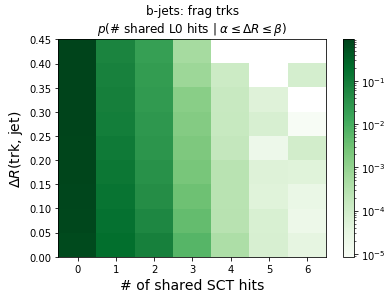

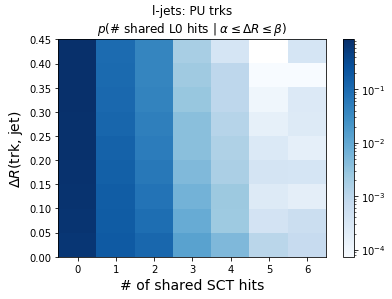

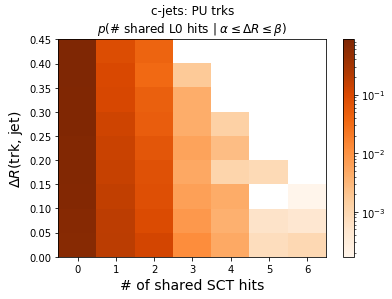

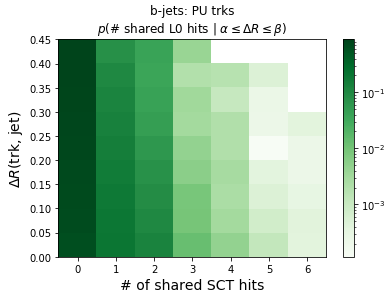

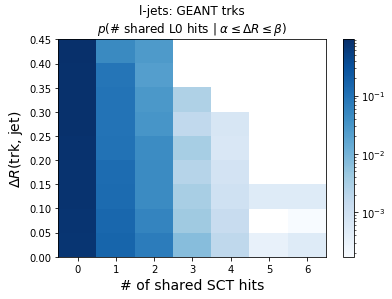

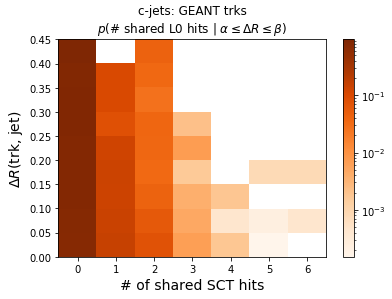

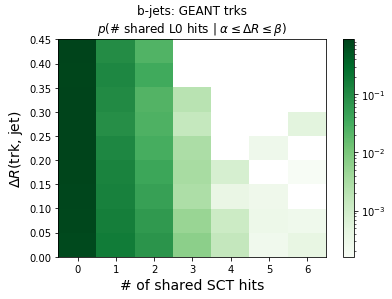

Plots for # of shared Si hits


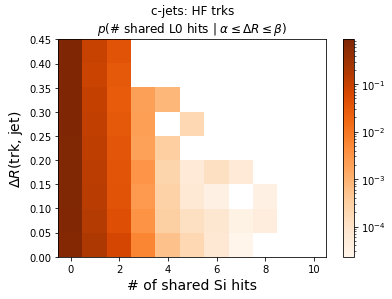

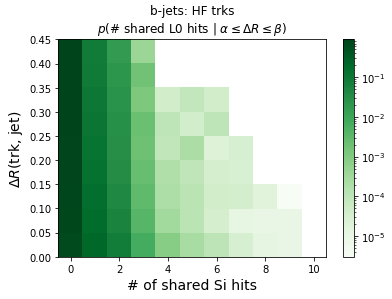

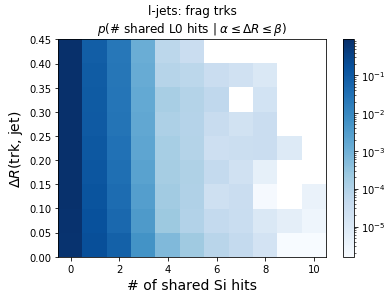

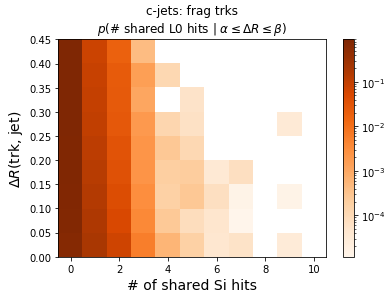

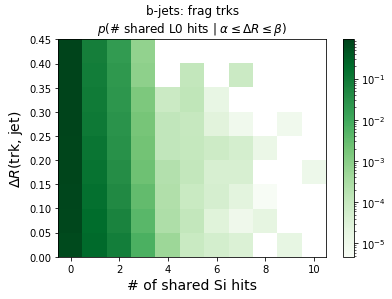

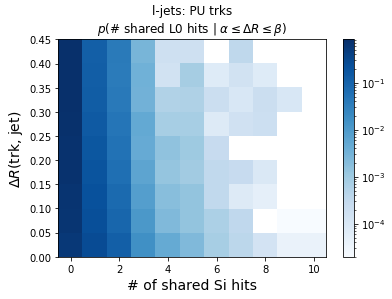

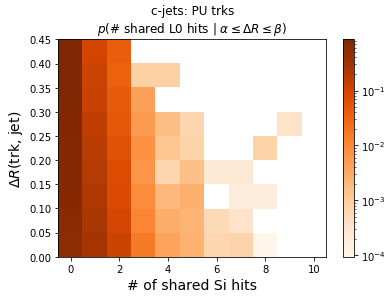

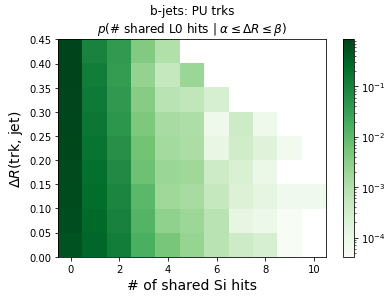

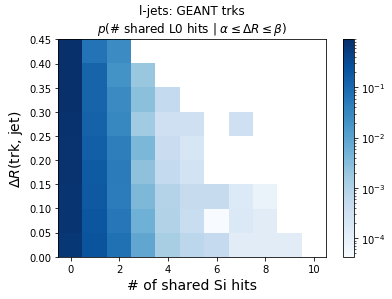

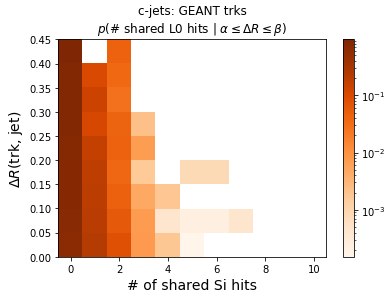

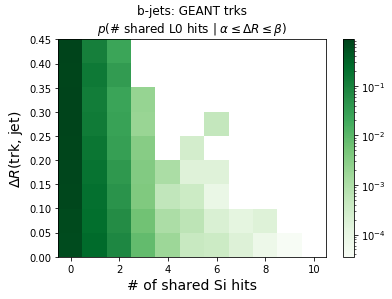

In [13]:
oneSharedHit = {}

for var, xLabel, vTag, nBinsX in zip(myVars, xLabels, vTags, nBinsXs):

    print('Plots for',xLabel)

    # Append a dictionary for this variable
    oneSharedHit[vTag] = {}
    
    for oi, orig_tag, l in zip([(0,1),2,-1,3],['HF','frag','PU','GEANT'],
                                   ['-', '--', '-.', ':']):

        # Apppend a dictionary for this track label
        oneSharedHit[vTag][orig_tag] = {}
        
        # Get the mask for the track origin
        if type(oi) == tuple:
            orig_mask = np.zeros_like(y_trks).astype(bool)
            for oix in oi:
                orig_mask = orig_mask | (o_trks==oix)
        else:
            orig_mask = (o_trks==oi)


        for yi, flav, cmap in zip(range(3), ['l','c','b'], ['Blues','Oranges','Greens']):

            if (flav == 'l') and (orig_tag == 'HF'):
                continue
        
            subfig_mask = orig_mask & (y_trks==yi)
            
            c,xe,ye = np.histogram2d(var[subfig_mask],dRs[subfig_mask], 
                       bins=(nBinsX,9),range=((-0.5,nBinsX-0.5),(0,0.45))) 

            myTitle = '{}-jets: {} trks\n'.format(flav, orig_tag)
            myTitle += r'$p($# shared L0 hits | $\alpha \leq \Delta R \leq \beta)$'

            cNorm = normHist2d(c,xe,ye,normCol=False, 
                               xlabel=xLabel, ylabel='$\Delta R$(trk, jet)', 
                               cmap=cmap, title=myTitle,
                               subDir='PU_studies',
                               figName='{}_vs_dR_{}jet_{}'.format(vTag,flav,orig_tag),
                               returnCounts=True)

            # Append the list for the hist values for the jet flavor
            # cNorm.shape (for IBL shared hits): (3,9)
            oneSharedHit[vTag][orig_tag][flav] = cNorm[1,:]
            
            plt.show()
            #break

Ok, so I think the conclusion from these $\Delta R$ studies are that there really *isn't* a $\Delta R$ dependence, so I think it's a lot *more* likely that this affect is comig from another effect.

I'll try to keep this information in the back of my mind to see if maybe correcting the track labelling helps clear it up a bit??

**Notes from chatting w/ Michael again**

So he thought that it was pretty hard to disentangle the colors of the columns from each other, and since we're really just trying to figure out how the $2^{nd}$ evolves w/r.t. $\Delta R$, I should just plot this columns a histogram.

In [14]:
ye.shape

(10,)

In [15]:
dRs = (ye[1:] + ye[:-1])/2

In [16]:
vTags

['sharedL0Hits', 'sharedPixHits', 'sharedSCTHits', 'sharedSiHits']

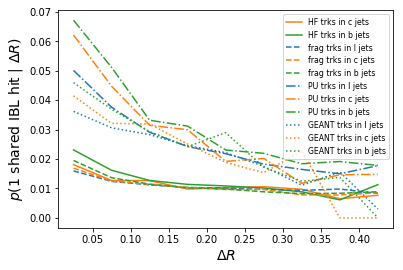

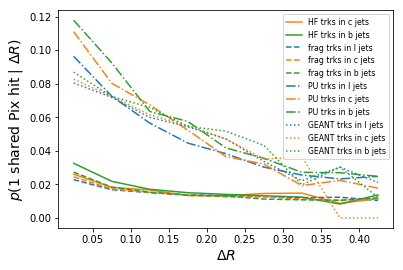

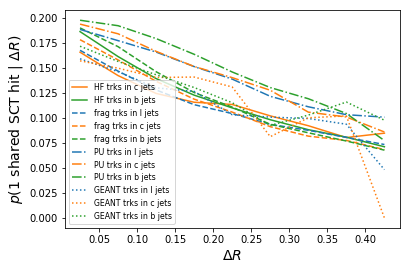

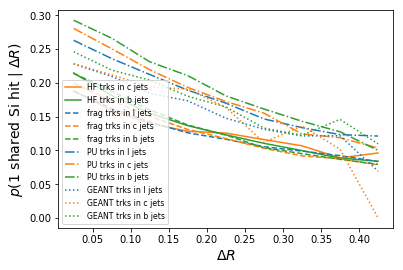

In [17]:
for vTag, det in zip(vTags, ['IBL','Pix','SCT','Si']):

    plt.figure()
    
    for orig_tag, l in zip(['HF','frag','PU','GEANT'],['-', '--', '-.', ':']):

        for yi, flav in zip(range(3), ['l','c','b']):

            if (flav == 'l') and (orig_tag == 'HF'):
                continue

            c = 'C{}'.format(yi)
            plt.plot(dRs,oneSharedHit[vTag][orig_tag][flav],
                     color=c,linestyle=l,
                     label='{} trks in {} jets'.format(orig_tag,flav))

    plt.xlabel('$\Delta R$',fontsize=14)
    plt.ylabel('$p$(1 shared {} hit | $\Delta R$)'.format(det),fontsize=14)
    plt.legend(fontsize=7.8)
    plt.savefig('../figures/PU_studies/ONE{}_vs_dR.pdf'.format(vTag),bbox_inches='tight')

    plt.show()


Ok, so this plot is kind of hard for me to interpret.

On the one hand, I do see more shared hits for lower $\Delta R$.

But I don't know if I understand
1. Why there are *more* shared hits for PU and GEANT than HF or frag

This seems to suggest that maybe this # of shared hits might coming PU tracks that are fake tracks, and are hence having lower quality.

2. Why the PU distribution for l-jets is also following this decreasing $\Delta R$ profile.

**Notes from talking to Michael:**

We looked at these plots together, and he agreed that there might be some interesting physics burried inside, but we weren't sure how to interpret it at the moment.

From my studies in the `Truth-Match-Prob` notebook, it seems like a different ordering for assigning the track labels might fix the issue (at least in part).

So before exploring why we have more "shared hits" for PU tracks in HF jets, I think I'm going to see how the resolution of the track labelling plays out.


**Event Displays**

But one more (pretty fun) idea that Michael had, was I could look into plotting event displays for jets inside of the event.

Since this notebook was getting rather long, I decided to do these studies in a new notebook: `Event-Displays`.



### 2. # of Si hits <a id='nSiHits'></a>
 
So turns out, I was using pretty *loose* selection criteria for the track quality, and I can suppress fakes by putting in a requirement of at least 9 Si tracks (or 11, depending on the track $\eta$), so I think the first order of business would be to look at some of these Si hits plots to see what's going on!

Then I could make plots of the # of Si hits vs. the track $\eta$ to see if this cut would allow me to mostly suppress PU.

In [12]:
mask.shape

(1500000, 15)

In [13]:
nPixHits = trk_xr.loc[:,:,'nPixHits'].values[ix][mask]
nSCTHits = trk_xr.loc[:,:,'nSCTHits'].values[ix][mask]

nSiHits = nPixHits + nSCTHits

In [14]:
tEta = trk_xr.loc[:,:,'eta'].values[ix][mask]

**Q:** Does this $\eta$ correspond to the $\eta$ for the track, or the $\Delta \eta$ with respect to the jet axis?

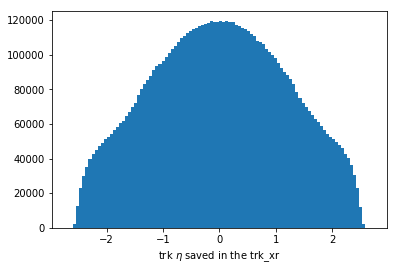

In [15]:
plt.hist(tEta,bins=100)
plt.xlabel('trk $\eta$ saved in the trk_xr')
plt.show()

Ok, so since the values range between (-2.5,2.5), this must be the $\eta$ corresponding to the detector coordinates. (This is good news for the variables that I wanted to cut on!) 

**Plot the Si hits broken down by trk origin + jet flavor**

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


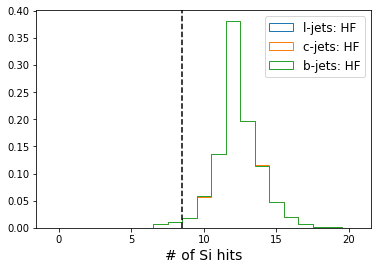

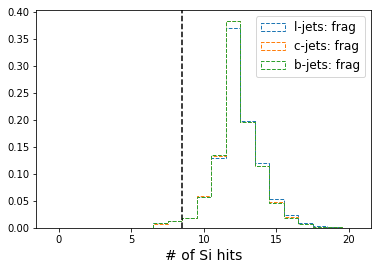

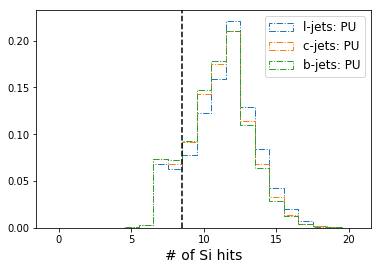

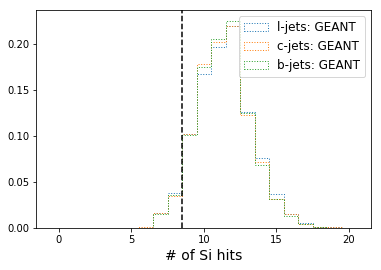

In [16]:
for oi, orig_tag, l in zip([(0,1),2,-1,3],['HF','frag','PU','GEANT'],
                               ['-', '--', '-.', ':']):

    # Get the mask for the track origin
    if type(oi) == tuple:
        orig_mask = np.zeros_like(y_trks).astype(bool)
        for oix in oi:
            orig_mask = orig_mask | (o_trks==oix)
    else:
        orig_mask = (o_trks==oi)

    plt.figure()

    for yi, flav in zip(range(3), ['l','c','b']):

        plt.hist(nSiHits[orig_mask & (y_trks == yi)],
                 range=(-0.5,20.5),bins=21,
                 histtype='step', density=True, 
                 color='C{}'.format(yi), linestyle=l,
                 label='{}-jets: {}'.format(flav,orig_tag))

    plt.legend(fontsize=12)  
    plt.xlabel("# of Si hits",fontsize=14)
    
    # Add a dashed line for if you're requiring @ least 9 Si hits to guide the eye
    ymin, ymax = plt.ylim()
    plt.plot([8.5,8.5],[ymin,ymax],'k--')
    plt.ylim(ymin,ymax)
    
    plt.savefig('../figures/PU_studies/nSiHits_{}.pdf'.format(orig_tag))

    plt.show()

Ok, so I'm a little bit dubious that there are some PU tracks with less than 7 Si hits.
I thought that looking at IP3D tracks meant we had a # Si hits $\geq$ 7 cut. Probably not the thing that I need to worry about most right now though.

Clearly cutting on the # of Si hits gets rid of a lot more PU than GEANT, so seems like a good deal!


**Plot the Si hits versus trk $\eta$**

Actually, the tight track selection uses a tighter criteria in the forward region, 
- $\geq$ 9 Si hits for $|\eta| < 1.65$
- $\geq$ 11 Si hits for $|\eta| < 1.65$

So I think it would be good to look at the # of Si hits vs $\eta$ broken down by the track origin.

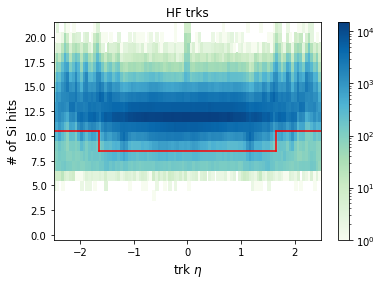

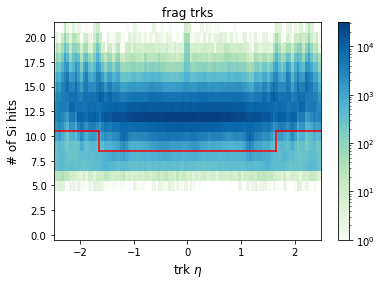

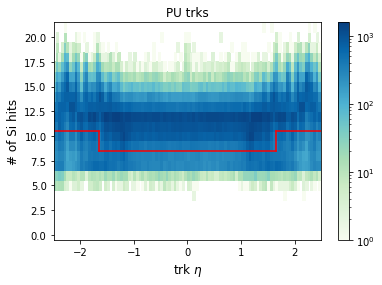

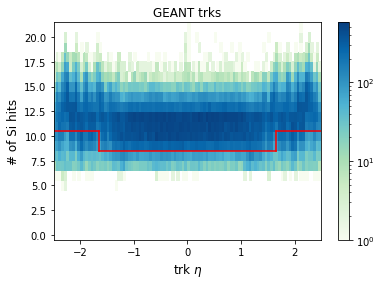

In [17]:
for oi, orig_tag, l in zip([(0,1),2,-1,3],['HF','frag','PU','GEANT'],
                                   ['-', '--', '-.', ':']):

    plt.figure()
    # Get the mask for the track origin
    if type(oi) == tuple:
        orig_mask = np.zeros_like(y_trks).astype(bool)
        for oix in oi:
            orig_mask = orig_mask | (o_trks==oix)
    else:
        orig_mask = (o_trks==oi)

    plt.hist2d(tEta[orig_mask],nSiHits[orig_mask], 
               bins=(100,22),range=((-2.5,2.5),(-0.5,21.5)),
               norm=LogNorm(), cmap="GnBu")

    plt.colorbar()

    plt.title('{} trks'.format(orig_tag))
    plt.xlabel('trk $\eta$', fontsize=12)
    plt.ylabel('# of Si hits', fontsize=12)

    # Add a line overlaying for the Si hits selection for the tight tracks
    plt.plot([-1.65,1.65],[8.5,8.5],'r-')
    
    plt.plot([-2.5,-1.65],[10.5,10.5],'r-')
    plt.plot([1.65,2.5],[10.5,10.5],'r-')
    
    plt.plot([-1.65,-1.65],[8.5,10.5],'r-')
    plt.plot([1.65,1.65],[8.5,10.5],'r-')
    
    plt.savefig('../figures/PU_studies/nSiHits_vs_eta_{}.pdf'.format(orig_tag))
    plt.show()

### 3. Track multiplicity distributions
 <a id='nTrkDist'></a>
 
Next, let's look into how these track multiplicity distributions are impacted by the PU cut... we're *hoping* this only changes the profile for the garbage tracks.

In [18]:
X_all = trk_xr.values
trk_origs = trk_xr.loc[:,:,'orig'].values

Add a new column to trk_origs for the number of Si hits.

In [19]:
nSiHits_all = trk_xr.loc[:,:,'nPixHits'].values+trk_xr.loc[:,:,'nSCTHits'].values

In [20]:
for nSiHits, varTag in zip([0,7,8,9], ['ip3d','nSi7','nSi8','nSi9']):

    Si_mask = (nSiHits_all >= nSiHits)
    
    for o, orig_tag, trk_label in zip([(0,1), 2, -1, 3], ['HF','frag','PU','GEANT'],
                                    ['heavy flavor', "fragmentation", "pile-up", "GEANT"]):

        if type(o) == tuple:
            orig_mask = np.zeros(15, dtype=np.bool)
            for oi in o:
                orig_mask = orig_mask | (trk_origs == oi)

            # For this jet, I can't just *add* up the origin mask, b/c the b-jets have 
            # this variable assigned as the mask values
            trkExists = (np.sum(X_all, axis=-1) != 0)

            orig_mask = orig_mask & trkExists

        else:
            orig_mask = (trk_origs == o)
            
        key = varTag + '_ntrk_' + orig_tag
        jet_df[key] = np.sum(orig_mask & Si_mask, axis=-1)
    

0 16
1 16


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


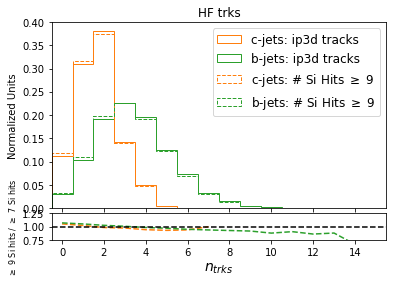

0 16
1 16
2 16


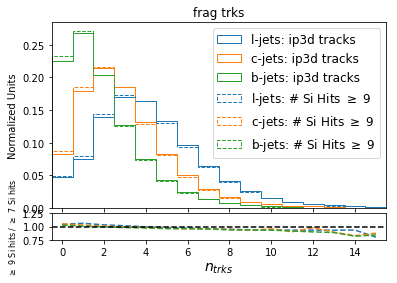

0 16
1 16
2 16


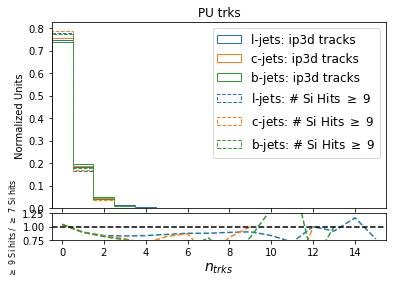

0 16
1 16
2 16


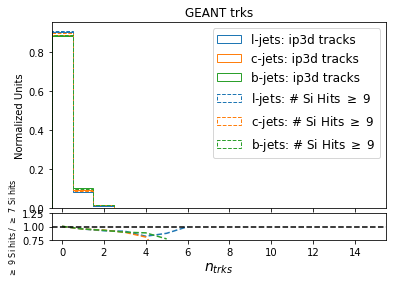

In [72]:
for orig_tag in ['HF','frag','PU','GEANT']:

    fig = plt.figure()
    gs = gridspec.GridSpec(7,1)
    ax1 = fig.add_subplot(gs[:6,0])
    ax2 = fig.add_subplot(gs[6:,0])
    
    ns = []
    
    #for nSiHits, vTag, l in zip([0,7,8,9], ['ip3d','nSi7','nSi8','nSi9'], ['-', '--', '-.', ':']):
    for nSiHits, vTag, l in zip([0,9], ['ip3d','nSi9'], ['-', '--']):
        
        key = vTag + '_ntrk_' + orig_tag

        leg_tag = 'ip3d tracks' if nSiHits == 0 else '# Si Hits $\geq$ {}'.format(nSiHits)
        
        ns.append([])
        
        for yi, pdg, flav in zip(range(3), [0,4,5],['l','c','b']):

            if orig_tag == 'HF' and yi == 0:
                continue
            
            
            mask = (jet_df.LabDr_HadF == pdg)

            n,e,_ = ax1.hist(jet_df.loc[mask,key],range=(-0.5,15.5),bins=16,
                             histtype='step', density=True, 
                             color='C{}'.format(yi), linestyle=l,
                             label='{}-jets: {}'.format(flav,leg_tag))
            ns[-1].append(n)

        
    # Plot the ratio below
    for yi in range(3):
        
        if orig_tag == 'HF' and yi == 0:
            continue
        i = yi-1 if orig_tag == 'HF' else yi
        
        print(i,len(n))
        ax2.plot((e[1:]+e[:-1])/2,ns[1][i]/ns[0][i],color='C{}'.format(yi), linestyle=l,)
    
    ax2.plot([-0.5,15.5],[1,1],'k--')
    
    ax1.legend(fontsize=12)   
    ax2.set_xlabel('$n_{trks}$',fontsize=14)
    ax1.set_ylabel('Normalized Units')
    ax2.set_ylabel('$\geq$ 9 Si hits / $\geq$ 7 Si hits',fontsize=8)
    ax1.set_xlim(-0.5,15.5)
    ax2.set_xlim(-0.5,15.5)
    ax2.set_ylim(0.75,1.25)
    ax1.set_title('{} trks'.format(orig_tag))
    plt.savefig("../figures/PU_studies/ntrks_9SiHits_{}.pdf".format(orig_tag),
                bbox_inches='tight')
    plt.show()


**Lesson:** This # of Si hits $\geq$ 9 cut doesn't have a big impact on the HF tracks, and mostly is helping us get rid of PU tracks.


**4. Comparing what the RNN has learned about fakes**
 <a id='rnnPerformance'></a>

- If the performance w/ the Si hits cut is better, this means we have a better rnn, and we could learn more from the track hit information
- If the perforamcne is the same, we've effectively learned about the fakes by selecting tracks efficiently with this variable
- If the performance is worse w/ the Si hits removed, this means it's learning a cleverer cut than what is currently implemented by the Si hits, and by cutting in the multi-dimensional space, it's learning how to reject the PU tracks. 


Also, there are two rnns that I can check, one trained with the auxiliary loss and the other trained w/o the auxiliary loss.


In [ ]:
dataTag

In [ ]:
leffs, ceffs, beffs, labels = [], [], [],[]

In [ ]:
subDir = 'mc16d_Topo_ttbar'

modelDir = "../models/{}/".format(subDir)
nTrkClasses=4

m2 = LSTM_trkClass(modelDir=modelDir,nFeatures=nFeatures, 
                  dataTag=dataTag, nTrkClasses=nTrkClasses,
                  alpha=1, loadModel=True)

trainingMetrics(m2.modelName,m2.modelDir)

leff, ceff, beff = getEffs(m2, X, y, ix, modelDir=m2.modelDir, subDir=subDir)
    
leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)
labels.append('model trained with auxiliary loss, evaluated on all the tracks')

In [ ]:
btagROC(beffs, leffs, ceffs, labels)

Next... get the track mask

In [ ]:
mask = getTrkMask(X)

In [ ]:
mask.shape

Ok, now just need the Si hits from the test set!

In [ ]:
nSiHits_all.shape

In [ ]:
nSiHits = nSiHits_all[ix]

In [ ]:
nSiHits.shape

In [ ]:
nSiHits_mask = (nSiHits >= 9)

In [ ]:
X_9Hits = X.copy()

In [ ]:
X_9Hits[~nSiHits_mask] = 0

In [ ]:
tag = '_9SiHits'
leff, ceff, beff = getEffs(m2, X_9Hits, y, ix, modelDir=m2.modelDir, subDir=subDir, tag=tag)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)
labels.append('model trained with auxiliary loss, evaluate on tracks w/ # Si Hits $\geq$ 9')

In [ ]:
labels = ['evaluated on all the tracks',
          'evaluate on trks w/ $\geq$ 9  Si Hits']

plotROCRatio(beffs[:2], leffs[:2], labels, rrange=(0.9,1.10),
             title='l-rej: rnn trained with $L = L_{jet} + L_{trk}$',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='lrej_9SiHits')

plotROCRatio(beffs[:2], ceffs[:2], labels, rrange=(0.9,1.10),
             ymax=100,title='c-rej: rnn trained with $L = L_{jet} + L_{trk}$',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='crej_9SiHits')

Ok, good news! We've *learned* from the hits of the tracks to eliminate these fakes

I think in answer to PF's question, I think our RNN is learning it's own selections, so I think we can improve by getting better efficeincies for selection HF tracks.

In [ ]:
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTag, loadModel=True)

for Xi,tag in zip([X, X_9Hits],['','_9SiHits']):

    leff, ceff, beff = getEffs(m, Xi, y, ix, modelDir=m.modelDir,subDir=subDir,tag=tag)
    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)


In [ ]:
m.model.summary()

In [ ]:
plotROCRatio(beffs[2:4], leffs[2:4], labels, rrange=(0.9,1.10),
             title='l-rej: rnn trained with just $L = L_{jet}$',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='lrej_9SiHits_jetLoss')

plotROCRatio(beffs[2:4], ceffs[2:4], labels, rrange=(0.9,1.10),
             ymax=100,title='c-rej: rnn trained with just $L = L_{jet}$',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='crej_9SiHits_jetLoss')

Ok, all you needed to do was feed in the pixel + SCT inputs, the auxiliary lose isn't helping with fakes in particular.

**Last check:** Am I loosing information about the fakes w/ the category embedding?

In [ ]:
embedTag = "3m_15trks_sd0_sz0_ptfrac_dr_grade_sd0_rev_logNorm"
m_embed = myLSTM(modelDir=modelDir, nFeatures=5, dataTag=embedTag, loadModel=True, doEmbedding=True)

In [ ]:
m_embed.modelName

In [ ]:
m_embed.model.summary()

Ok, so recall from the root_to_np preprocessing, I had to **add one** to the track grade to make it obvious which tracks were assigned to category 0, and which were getting masked by the rnn.

In [ ]:
grade_test = trk_xr.loc[:,:,'ip3d_grade'].values[ix] 
grade_test = grade_test + 1

In [ ]:
np.min(grade_test),np.max(grade_test)

In [ ]:
X_embed = np.concatenate((X[:,:,:2],X[:,:,-4:-2],np.reshape(grade_test,(-1,nTrks,1))), axis=-1)

In [ ]:
X_embed.shape

In [ ]:
X_embed_9Hits = X_embed.copy()
X_embed_9Hits[~nSiHits_mask] = 0

In [ ]:
np.max(X_embed-X_embed_9Hits)

In [ ]:
trainingMetrics(m_embed.modelName,m_embed.modelDir)

In [ ]:
for Xi,tag in zip([X_embed, X_embed_9Hits],['','_9SiHits']):
    
    leff, ceff, beff = getEffs(m_embed, Xi, y, ix, modelDir=m_embed.modelDir,subDir=subDir,tag=tag)
    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)


In [ ]:
labels = ['evaluated on all the tracks',
          'evaluate on trks w/ $\geq$ 9  Si Hits']

plotROCRatio(beffs[-2:], leffs[-2:], labels, rrange=(0.9,1.10),
             title='l-rej: rnn trained with category embedding',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='lrej_9SiHits_embed')

plotROCRatio(beffs[-2:], ceffs[-2:], labels, rrange=(0.9,1.10),
             ymax=100,title='c-rej: rnn trained with category embedding',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='crej_9SiHits_embed')

Ok, so this is also super interesting, the rnn trained with the category information has a better l-rej when we take out these poor quality tracks! It still does slightly worse w/ c-rej though, but this makes sense because PU tracks hurt us most with the l-rej.

 
<img src="../figures/PU_studies/roc_PU_vs_GEANT.pdf" width="400">

Another thing to note, we really aren't seeing any gains w/ the network trained with $L_{trk}$, so I'll be working with the network just training w/ $L_{jet}$ for future comparisons.


In [ ]:
btagROC([beffs[0],beffs[2]], [leffs[0],leffs[2]], [ceffs[0],ceffs[2]], 
        ['train w/ $L_{jet}+L_{trk}$','train w/ $L_{jet}$'])

Note: The light rejection training just with $L_{jet}$ is already at 800.

#### Impact of the dead pixel modules

I showed an version of these plots in one of our SLAC HH / H+ISR meetings, and Caterina was concerned about the impact of ignoring the dead pixel modules when calculating the # Si hits. She said an easy way to check this is to remake this plot cutting on tracks w/ at least 7 Si hits, so I think I'm set up to do this right here!

In [ ]:
sevenSiHits = (nSiHits >= 7)

X_7Hits = X.copy()
X_7Hits[~sevenSiHits] = 0

Plan: Makes these curves for the $L_{jet}$ model trained with the hit information.

In [ ]:
tag = '_7SiHits'

leff, ceff, beff = getEffs(m, X_7Hits, y, ix,subDir=subDir)#, modelDir=m.modelDir,subDir=subDir,tag=tag)
leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [ ]:
labels = ['evaluate on all the tracks',
          'evaluate on trks w/ $\geq$ 7  Si Hits']

plotROCRatio([beffs[2],beffs[-1]], [leffs[2],leffs[-1]], labels, rrange=(0.9,1.10),
             title='l-rej: rnn trained with $L = L_{jet}$ and hits',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='lrej'+tag)

plotROCRatio([beffs[2],beffs[-1]], [ceffs[2],ceffs[-1]], labels, rrange=(0.9,1.10),
             ymax=100,title='c-rej: rnn trained with $L = L_{jet}$ and hits',
             binomialErrors=True,nTest=1.5e6, 
             subDir='PU_studies',tag='crej'+tag)

#### Domain adaptation

When I showed Michael some versions of these plots, he said that I wasn't really making a fair comparison, because I was evaluating the models outside of their training regimes.

**Plan:** Retrain the hits and category embedding models with a modified training set of tracks with at least 9 Si hits.

I'm going to create and save the training datasets here, and then submit the jobs to the gpu as well. Since these are two separate training sets, I should be able to train in parallel.


There's a flag `dataTag` in `trainNet.py`, so it will be straightforward to train different iterations of this model.


In [ ]:
f_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

f = h5py.File(f_name,"r")
    
X_tr = f['X_train'][:]
y_tr = f['y_train'][:]
y_trk_tr = f['y_trk_train'][:].astype(int)
ix_tr = f['ix_train'][:]
w_tr = f['weights_train'][:]

f.close()

In [ ]:
dataTag_9SiHits = dataTag + '_9SiHits'

In [ ]:
nSiHits_tr = nSiHits_all[ix_tr]
SiHits_mask_tr = (nSiHits_tr >= 9)

X_tr[~SiHits_mask_tr] = 0
y_trk_tr[~SiHits_mask_tr] = 0


In [ ]:
fout_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag_9SiHits)

fout = h5py.File(fout_name,"w")

fout.create_dataset('X_train',data=X_tr)
fout.create_dataset('y_train',data=y_tr)
fout.create_dataset('y_trk_train',data=y_trk_tr)
fout.create_dataset('weights_train',data=w_tr)
fout.create_dataset('ix_train',data=ix_tr)

fout.close()

**To do:** Make the plots to c.f. when you're just training and evaluating in the same domain.

*Possible next step: Also retrain the category embedding model with this better track selection.*

**Load in the model**

In [ ]:
m_9SiHits = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
                   dataTag=dataTag_9SiHits, loadModel=True)


In [ ]:
trainingMetrics(m_9SiHits.modelName,m_9SiHits.modelDir)

**Evaluate on the test set with the higher quality tracks.**

In [ ]:
# I still need to append the tag "train" to distinguish the roc curves that I just 
# evaluated on tracks that had at least 9 Si hits
leff, ceff, beff = getEffs(m_9SiHits, X_9Hits, y, ix, 
                           modelDir=m_9SiHits.modelDir,subDir=subDir,tag='train')
leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [ ]:
tag = 'train_9SiHits'

labels = ['train + evaluate on all the tracks',
          'train + evaluate on trks w/ $\geq$ 9  Si Hits']

plotROCRatio([beffs[2],beffs[-1]], [leffs[2],leffs[-1]], labels, rrange=(0.9,1.10),
             title='l-rej: rnn trained with $L = L_{jet}$ and hits',
             binomialErrors=True,nTest=1.5e6, colors=['C0','C3'],
             subDir='PU_studies',tag='lrej'+tag)

plotROCRatio([beffs[2],beffs[-1]], [ceffs[2],ceffs[-1]], labels, rrange=(0.8,1.10),
             ymax=100,title='c-rej: rnn trained with $L = L_{jet}$ and hits',
             binomialErrors=True,nTest=1.5e6, colors=['C0','C3'],
             subDir='PU_studies',tag='crej'+tag)

**Lesson:** 
- For the rnn trained with higher purity tracks, it actually does quite a bit worse for charm, consistent with our story that we want as many tracks as possible for c-rej
- For the l-rej, it see a similar trend between whether we're just training on all the tracks, or the tracks with the higher purity selection.

In [ ]:
tag = 'trainAndEval_9SiHits'

labels = ['train + evaluate on all the tracks',
          'train + on all, evalulate on $\geq$ 9  Si Hits',
          'train + evaluate on trks w/ $\geq$ 9  Si Hits']

plotROCRatio(beffs[2:4]+[beffs[-1]], leffs[2:4]+[leffs[-1]], labels, rrange=(0.9,1.10),
             title='l-rej: rnn trained with $L = L_{jet}$ and hits',
             binomialErrors=True,nTest=1.5e6, colors=['C0','C1','C3'],
             subDir='PU_studies',tag='lrej'+tag)

plotROCRatio(beffs[2:4]+[beffs[-1]], ceffs[2:4]+[ceffs[-1]], labels, rrange=(0.8,1.10),
             ymax=100,title='c-rej: rnn trained with $L = L_{jet}$ and hits',
             binomialErrors=True,nTest=1.5e6, colors=['C0','C1','C3'],
             subDir='PU_studies',tag='crej'+tag)

For the c-rej, the looser track selection lets us learn a more optimal decision boundary for the tigher selection of tracks!

### 5. RNN Activations: jet with a fake
 <a id='fakeTrk'></a>
 
 Ok, so I want to start looking into some of these activations for the rnn when evaluating a jet that has a track that has *less than 9 Si hits*
 
 The question that I'm trying to answer is whether the RNN is *using* the combination of 
 - \# of pixel hits
 - \# of SCT hits
 to *ignore* the fake track, or if it's just not using the pixel and SCT hits variables at all.
 
Personally, I think the rnn is learning to ignore the fake track, but I think by delving into these activations for individual jets, I'm going to learn some cool stuff about what the RNN is learning!

**Step 1: How often do we have jets with tracks like this in the test set?**

Also, maybe look at these numbers broken down by jet flavor?

In [ ]:
nSiHits_mask.shape

In [ ]:
nGoodTrks = np.sum(nSiHits_mask,axis=1) 
nGoodTrks

In [ ]:
nTrks_ip3d = jet_df.loc[ix,'ip3d_ntrk'].values
nTrks_ip3d

In [ ]:
selectionApplied = np.sum(nGoodTrks != nTrks_ip3d)
selectionApplied

In [ ]:
selectionApplied / 1.5e6

Oh, interesting! Such a track will pop up in about 14% of the jets.

This was a little bit of a bigger effect than I thought originally.

**Step 2: Print out some individual jets**

In [ ]:
ptfrac = trk_xr.loc[:,:,'ptfrac'].values[ix]
dr = trk_xr.loc[:,:,'dr'].values[ix]

In [ ]:
X_all.shape

In [ ]:
trk_xr.coords['var']

In [ ]:
for i_jet, n1, n2, jet, yi in zip(ix, nGoodTrks, nTrks_ip3d, X, y):
    if n1 != n2:
        
        print('yi = {}, n1 = {}, n2 = {}, i_jet = {}'.format(yi,n1,n2,i_jet))
        
        for i_trk, trk in enumerate(jet):
            
            if np.sum(trk) == 0:
                break
            
            print('Track {}:'.format(i_trk + 1))
            print('  sd0 = ',trk[0])
            print('  sz0 = ',trk[1])
            print('  nNextToInnHits = ',trk[2])
            print('  nInnHits = ',trk[3])
            print('  nsharedBLHits = ',trk[4])
            print('  nsplitBLHits = ',trk[5])
            print('  nsharedPixHits = ',trk[6])
            print('  nsplitPixHits = ',trk[7])
            print('  nsharedSCTHits = ',trk[8])
            
            print('  ptfrac = ',trk_xr.loc[i_jet,i_trk,'ptfrac'].values)
            print('  dr = ',trk_xr.loc[i_jet,i_trk,'dr'].values)
            print('  nPixHits = ',trk_xr.loc[i_jet,i_trk,'nPixHits'].values)
            print('  nSCTHits = ',trk_xr.loc[i_jet,i_trk,'nSCTHits'].values)

        break

Ok, this makes sense, because the first track in this jet is *failing* the specified # of Si hits $\geq$ 9 cut.

**Step 3: Get these activations**

So I think I should start with the network that I trained with just the $L_{jet}$ loss trained with the hits, since Michael said this is the one that I should be comparing to right now, but then I could move onto the model that I was training with the embedding for the comparison of the gains that I'm trying to claim.

In [ ]:
m.model.summary() 

Ok, since this model was trained with the `return_sequences` flag set to False, I'm going to need to 
1. Define a new model
2. Load in the weights from this model

to plot these activations.

In [ ]:
# Defining the architecture
nHidden = 50

trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking(name='Mask')(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=True,name="LSTM")(masked_input)

m_act = Model(trk_inputs, lstm)

In [ ]:
m_act.summary()

Ok, so I wasn't sure whether Michael wanted me to plot $c_t$ or $h_t$, but when I use the `return_sequences` option, I think it's just returning $h_t$, so I'm just going to plot this.

I think I can access $c_t$ if I use the `return_state` flag.

In [ ]:
# Load in the weights
m_act.get_layer("LSTM").set_weights(m.model.get_layer("LSTM").get_weights())

**Step 4: Make some plots**

I'm just going to make these plots for jets that have a track *failing* this cut.

In [ ]:
cmaps = ['Blues','Oranges','Greens','Reds']

In [ ]:
for i_jet, n1, n2, jet, yi in zip(ix[:200], nGoodTrks, nTrks_ip3d.astype(int), X, y.astype(int)):
    if n1 != n2 and n2 <= 15:
        
        print('yi = {}, n1 = {}, n2 = {}, i_jet = {}'.format(yi,n1,n2,i_jet))
        
        # Plot the activations
        acts = m_act.predict(jet.reshape(1,nTrks,nFeatures)).squeeze()[:n2]
            
        plt.figure()
        plt.imshow(acts.T, cmap=cmaps[yi], aspect='auto')

        plt.xticks(np.arange(n2),np.arange(n2)+1)#,fontsize=14)
        plt.xlabel('Track sorted by $s_{d0}$',fontsize=14)
        plt.ylabel('RNN\'s hidden state activations',fontsize=12) 
        
        for i_trk, trk in enumerate(jet):
            
            if np.sum(trk) == 0:
                break

            # If the sum of the pix + SCT hits < 9, emphasize this track
            if trk_xr.loc[i_jet,i_trk,'nPixHits'].values + trk_xr.loc[i_jet,i_trk,'nSCTHits'].values < 9:
                
                plt.plot([i_trk-0.5,i_trk-0.5],[-0.5,nHidden-0.5],'k',linewidth=10 if i_trk == 0 else 5 ) # left
                plt.plot([i_trk+0.5,i_trk+0.5],[-0.5,nHidden-0.5],'k',linewidth=10 if i_trk==n2-1 else 5) # right
                plt.plot([i_trk-0.5,i_trk+0.5],[nHidden-0.5,nHidden-0.5],'k',linewidth=10) # top
                plt.plot([i_trk-0.5,i_trk+0.5],[-0.5,-0.5],'k',linewidth=10) # bottom
           
        plt.savefig('../figures/PU_studies/hiddenActivations/jet{}.pdf'.format(i_jet),bbox_inches='tight')
        plt.show()    
        #break

Am I just imagining this, or does it look like it's easier to ignore fake tracks in light jets?

**Analysis:**

Ok, so looking at these plots, I think they make sense, we're seeing that the when you have a fake track jet in the sequence, the hidden state does not change as much.

*Is there a way I can quantify this?*

Plan: For each track (not including the first one), I should calculate the (absolute value?) difference between it and the previous vector.

- If I compare the fake tracks and normal tracks, If I see a larger mean for the not fake tracks, this will support my conclusion.
- To get an intution, I'm going to plot these curves like histograms, and then on the figure, I'm going to put in the mean and std dev of each distribution

In [ ]:
dcell_good = []
dcell_fake = []

for i_jet, n1, n2, jet, yi in zip(ix[:10000], nGoodTrks, nTrks_ip3d.astype(int), X, y.astype(int)):
    
    if (n1 != n2) and n2 <= 15:
        
        acts = m_act.predict(jet.reshape(1,nTrks,nFeatures)).squeeze()
            
        for i in range(1,n2):
            dcell = (acts[i] - acts[i-1]).squeeze()
            
            if trk_xr.loc[i_jet,i_trk,'nPixHits'].values + trk_xr.loc[i_jet,i_trk,'nSCTHits'].values < 9:
                dcell_fake.append(dcell)
            else:
                dcell_good.append(dcell)
                
                
dcell_good = np.concatenate(dcell_good,axis=0)
dcell_fake = np.concatenate(dcell_fake,axis=0)


In [ ]:
myRange = (-0.5,0.5)
nBins=100

plt.hist(dcell_fake, bins=nBins, range=myRange,
         color='royalblue', histtype='step', density=True,
         label='trks w/ 7 $\leq$ Si hits $<$ 9')

plt.hist(dcell_good, bins=nBins, range=myRange,
         color='hotpink', histtype='step', density=True, 
         label='trks w/ Si hits $\geq 9$')

plt.legend()
plt.xlabel('$\Delta h_t$',fontsize=14)


plt.text(-0.5,11.5,'$\mu$ = {:.2}, $\sigma$ = {:.2}'.format(np.mean(dcell_fake),np.std(dcell_fake)),
         color='royalblue',fontsize=12)
plt.text(-0.5,10.25,'$\mu$ = {:.2}, $\sigma$ = {:.2}'.format(np.mean(dcell_good),np.std(dcell_good)),
         color='hotpink',fontsize=12)

plt.savefig('../figures/PU_studies/hiddenActivations/dCell.pdf')
plt.show()

